# 2nd Notebook for Machine Learning Intro Lecture

# 1. Softmax Multinomial Regression

# 2.  Quadratic Discriminant Analysis

- In QDA, we caclulate the posteriori class probabilities like that:
$$
p(y = k | X) = \pi_k |\Sigma_k|^{-\frac{1}{2}}\exp(- \frac{1}{2} x^T\Sigma_k^{-1}x - \frac{1}{2} \mu_k^T \Sigma_k^{-1} \mu_k + x^T \Sigma_k^{-1} \mu_k 
$$
* thus, we need those three ingredients for each of the $j = 1, ..., k$ classes:

    * $\hat{\pi}_j = \frac{n_j}{n}$ 
    * $\hat{\mu}_j = \sum_{i: y_i = j} \frac{x_i}{n_j}$  
    * $\hat{\Sigma_j} = \frac{1}{n_j - 1} \sum_{i: y_i = j} (x_i - \hat{\mu}_j) (x_i - \hat{\mu}_j)^T $  


### Implementation

Function to train the QDA model

In [82]:
trainQDA = function(target, data) {
  
  n = nrow(data)
  # which classes do we have?
  classes = levels(data[, target])
  target.col = which(colnames(data) == target)
  
  # over how many target classes do we iterate=
  k = length(classes)
  
  # initilialize empty storage list
  storage = rep(list(0), k)
  
  # calculate ingredients for each class
  for(j in 1:k) {
    
    class.j = classes[j]
    n.class = length(which(data[,target] == class.j))
    
    # prior
    prior.j = n.class / n
    
    # mu vector
    X.j = data[which(data[ ,target] == class.j), - (which(colnames(data) == target))]
    mu.j = apply(X = X.j, MARGIN = 2, mean)
    
    # covariance matrix
    cov.j = cov(X.j)
    
    # store results in nested list
    storage.j = rep(list(0), 4)
    storage.j[[1]] = class.j
    storage.j[[2]] = prior.j
    storage.j[[3]] = mu.j
    storage.j[[4]] = cov.j
    storage[[j]] = storage.j
  }
  return(storage)
}

Function to predict on a trained QDA model

In [83]:
predictQDA = function(model, data, out.mode = "probs") {
  
  # get info from model, purrr packages helps in data wrangling tasks
  classes = unlist(purrr::map(model, 1))
  p = length(unlist(model[[1]][3]))
  k = length(classes)
  
  # stupid re-transpose to stick better with lecture
  data = t(data)
  
  # calculate probabilities for each possible class
  storage = cbind(classes, rep(0, k))
  colnames(storage) = c("class", "posteriori")
  for (j in 1:k) {
    
    # retrieve the three ingredients from the trained model
    priori.j = unlist(model[[j]][2])
    mu.j = matrix(unlist(model[[j]][3]))
    cov.j = matrix(unlist(model[[j]][4]), nrow = p)
    
    # invert covariance matrix only once
    inv.cov.j = solve(cov.j)
    # compute posteriori like in lecture
    posteriori.j = priori.j * det(cov.j)^(-0.5) * 
      exp(-0.5 * t(data) %*% inv.cov.j %*% data - 0.5 * t(mu.j) %*% inv.cov.j %*% mu.j + t(data) %*% inv.cov.j %*% mu.j)
    
    # smart and elegant way
    #TODO: discuss w/ Christoph
    # dmnorm(t(data), mean = t(mu.j), varcov = cov.j*priori.j)
    
    storage[j, 2] = posteriori.j
  }
  # normalize to [0, 1] and round to 5 decimals
  storage[, 2] = round(as.numeric(storage[, 2])/ sum(as.numeric(storage[, 2])), 5)
  
  # return major class or probability scores
  if (out.mode == "category") {
    return(storage[which(storage[, 2] == max(storage[, 2])), 1])
  } else if (out.mode == "probs") {
    return(storage)
  }
}



### Evaluation

Train and test on good old iris data set

In [84]:
data(iris)
set.seed(1327)
trainSize = 3/5
trainIndices = sample(x = seq(1, nrow(iris), by = 1), size = ceiling(trainSize * nrow(iris)), replace = FALSE)
irisTrain = iris[ trainIndices, ]
irisTest = iris[ -trainIndices, ]

In [85]:
# train
model = trainQDA(target = "Species", data = irisTrain)
# predict on one observation
testPred = predictQDA(model = model, data = irisTrain[2, 1:4], out.mode = "probs")


In [86]:
# Evaluate performance on test set
# strange thing with the t(x), check that again
testPreds = apply(irisTest[, 1:4], MARGIN = 1 , 
                  function(x) predictQDA(model = model, data = t(x), out.mode = "category"))

results = data.frame(cbind(as.character(irisTest[, 5]), testPreds))
colnames(results) = c("true", "prediction")                      
print(table(results))
print(paste0("mmce: ", length(which(results$true != results$prediction)) / nrow(results)))
                      

            prediction
true         setosa versicolor virginica
  setosa         20          0         0
  versicolor      0         15         8
  virginica       0          0        17
[1] "mmce: 0.133333333333333"


# 3. naive Spam Filter

There are lots of different blog posts out there:
* We could include the data from this [Sms classifier](https://rpubs.com/mzc/mlwr_nb_sms_spam) later
* [this python nltk implement looks also interesting](https://cambridgespark.com/content/tutorials/implementing-your-own-spam-filter/index.html)
* [they use a bigger database](https://www.r-bloggers.com/build-a-spam-filter-with-r/)



### Theory

Remember the naive Bayes formula for the posteriori probabilities:

$$
p(y = k | x) = p(y = k) * \prod_{j = 1}^p p(x_j | y = k)
$$

Thus, we need two ingredients to calculate the class-wise posteriori probabilities:

1. prioris: $p(y = k) = \frac{n_k}{n}$
2. conditional probabilities for all classes $k$ and features $j$: $p(x_j|y = k)$

We use this to implement a rudimentary spam-detector!


### Implementation

#### Data

In [111]:
# train data
spam = c("buy drugs online from our pharma",
  "buy insurance at low prices now")
ham = c("I was writing for statistics advice",
  "newsletter from your favorurite statistics blog",
  "good article on statistics applications")

all = c(spam, ham)
# convert to word vcorpi
corpusAll = tm::VCorpus(tm::VectorSource(all))
corpusHam = tm::VCorpus(tm::VectorSource(ham))
corpusSpam = tm::VCorpus(tm::VectorSource(spam))

# compute term document matrix
DTM = tm::DocumentTermMatrix(corpusAll)
(wordMatrix = as.data.frame(as.matrix(DTM)))
spamMatrix = wordMatrix[1:length(spam), ]
hamMatrix = wordMatrix[(length(spam) + 1):length(all), ]


advice,applications,article,blog,buy,drugs,favorurite,for,from,good,⋯,newsletter,now,online,our,pharma,prices,statistics,was,writing,your
0,0,0,0,1,1,0,0,1,0,⋯,0,0,1,1,1,0,0,0,0,0
0,0,0,0,1,0,0,0,0,0,⋯,0,1,0,0,0,1,0,0,0,0
1,0,0,0,0,0,0,1,0,0,⋯,0,0,0,0,0,0,1,1,1,0
0,0,0,1,0,0,1,0,1,0,⋯,1,0,0,0,0,0,1,0,0,1
0,1,1,0,0,0,0,0,0,1,⋯,0,0,0,0,0,0,1,0,0,0


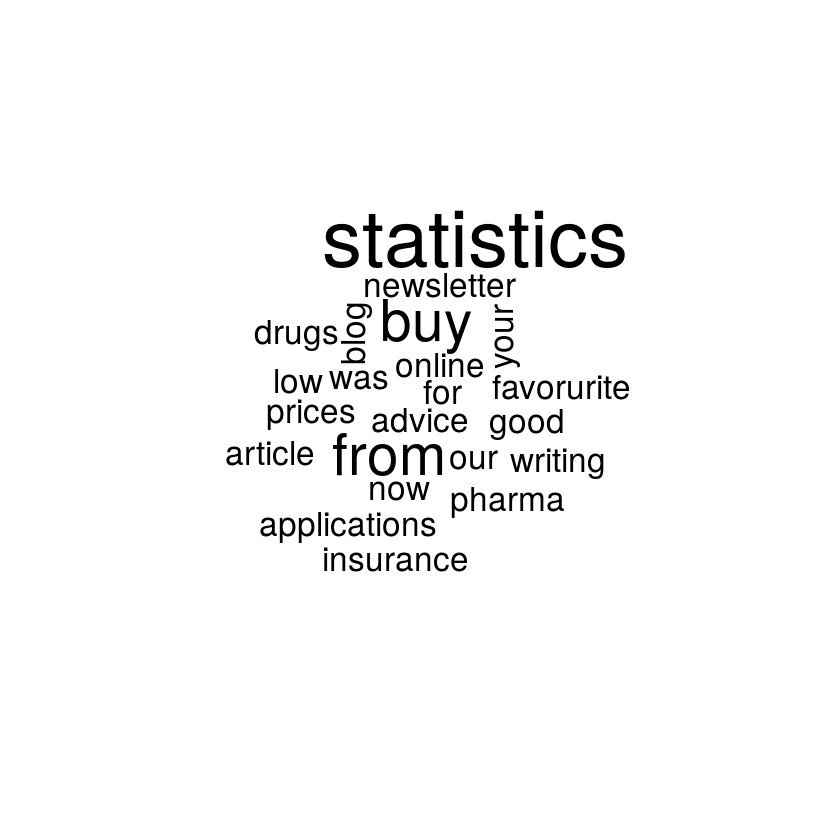

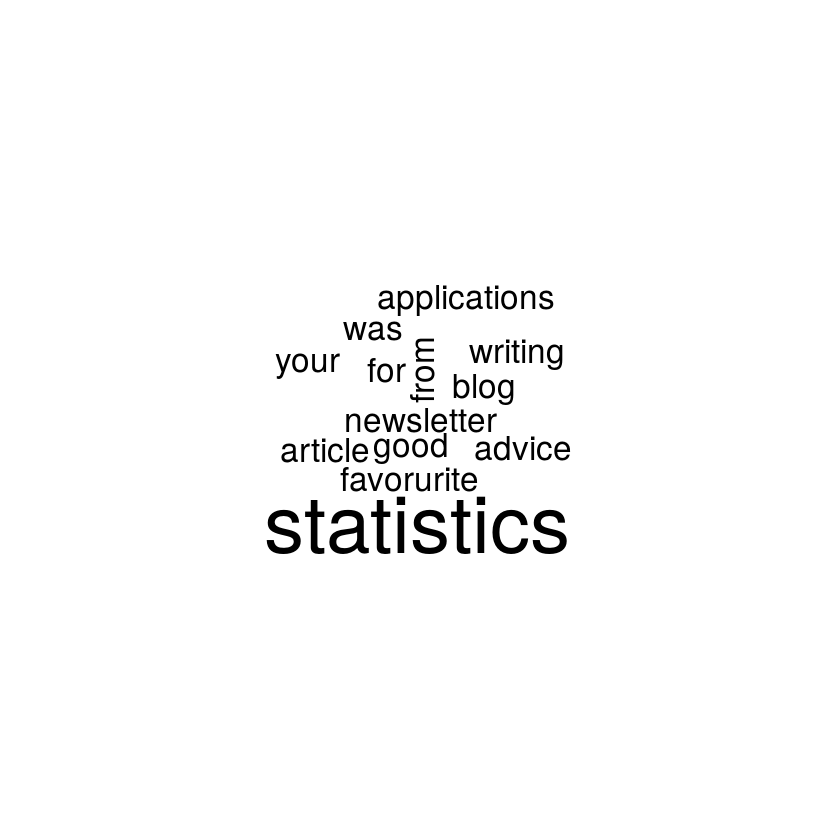

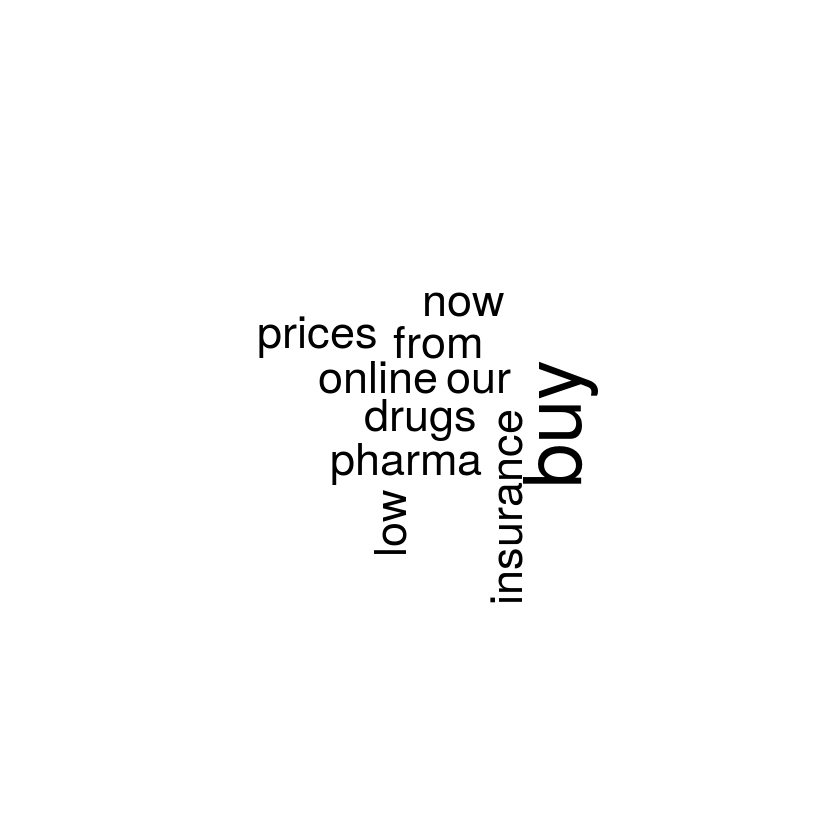

In [112]:
# Zueckerle. wordclouds per class
wordcloud::wordcloud(corpusAll, min.freq = 1)
wordcloud::wordcloud(corpusHam, min.freq = 1)
wordcloud::wordcloud(corpusSpam, min.freq = 1)

#### Training

In [113]:
# calculate ingredients

# prioris:
prioriHam = length(ham) / length(all)
prioriSpam = length(spam) / length(all)

# probablity vectors for each class:
# p(occurence term | y = k)
# spam
pSpam = apply(spamMatrix, MARGIN = 2, function(x) sum(x) / nrow(spamMatrix) )
pHam = apply(hamMatrix, MARGIN = 2, function(x) sum(x) / nrow(hamMatrix))
# assign super low values to 0-prob terms: 0.01
pSpam = ifelse(pSpam == 0, 1/length(pSpam), pSpam)
pHam = ifelse(pHam == 0, 1/length(pHam), pHam)

In [114]:
# function that calculates posteriori per class
scoreClass = function(test, probVector, prior) {
  # transform to document term matrix (vector)
  testMatrix = as.data.frame(as.matrix(tm::DocumentTermMatrix(tm::VCorpus(tm::VectorSource(test)))))

  # calculate p(word occurence | y = k) for each word in test, remove NAs and multiply them
  # multiply with prior value, this is our posteriori
  return(round(prior * prod(probVector[names(testMatrix)], na.rm = TRUE), 6))
}

# wrapper for both cases
classifySpamNaive = function(test, pSpam, pHam, prioriSpam, prioriHam, output = "class") {

  # calculate posterioris
  postSpam = scoreClass(test = testMail, probVector = pSpam, prior = prioriSpam)
  postHam = scoreClass(test = testMail, probVector = pHam, prior = prioriHam)

  # classify
  class = if (postSpam > postHam) {
    class = "spam"
  } else {
    class = "ham"
  }

  # return results
  if (output == "class") {
    return(class)
  } else if (output == "probs") {
    return(list(c(postSpam = postSpam, postHam = postHam, class = class)))
  }
}

#### Test and evaluate

In [115]:
# Test on "real world data"

testMail = "buy now online low price insurance"
classifySpamNaive(test = testMail, pSpam = pSpam, pHam = pHam,
  prioriSpam = prioriSpam, prioriHam = prioriHam, output = "probs")

testMail = "buy drug based pharma insurance online"
classifySpamNaive(test = testMail, pSpam = pSpam, pHam = pHam,
  prioriSpam = prioriSpam, prioriHam = prioriHam, output = "probs")

testMail = "good article for your statistics newsletter"
classifySpamNaive(test = testMail, pSpam = pSpam, pHam = pHam,
  prioriSpam = prioriSpam, prioriHam = prioriHam, output = "probs")

[[1]]
postSpam  postHam    class 
 "0.025"      "0"   "spam"

[[1]]
postSpam  postHam    class 
  "0.05"  "3e-06"   "spam"

[[1]]
  postSpam    postHam      class 
       "0" "0.002469"      "ham"

# 4. Different decision boundaries via mlr

mlr_a_4.Rnw